In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

/home/nshafiabadi/anaconda3/envs/virtualenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_0')
model = AutoModelForMaskedLM.from_pretrained('google/multiberts-seed_0').to(device)

/home/nshafiabadi/anaconda3/envs/virtualenv/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


cpu


In [3]:
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [12]:
sentence = 'the authors [MASK]'
encoded_input = tokenizer(sentence, return_tensors="pt")
tokens = tokenizer.tokenize(sentence, add_special_tokens=True)
tokens

['[CLS]', 'the', 'authors', '[MASK]', '[SEP]']

In [13]:
output = model(**encoded_input, output_attentions=True, output_hidden_states=True)

In [14]:
for key in output.keys():
    print(key)

logits
hidden_states
attentions


## View attentions matrices

The self-attention $a_{j \rightarrow i}$ describes how important is the $j$-th token to build the representation of the $i$-th token. We now that $a_{j \leftarrow j}$ is probability distribution

In [15]:
attentions = output.attentions
print(len(attentions))  # The encoder attention is a list of 12 tensors, one for each `BertEncoderLayer` in the model.
print(attentions[-1].shape) # Each attention is a `[batch_size ✕ n_heads ✕ input_sequence_length ✕ input_sequence_length]`.

12
torch.Size([1, 12, 5, 5])


In [29]:
# the first attention head on the last layer
first_self_attention_head = attentions[-1][0, -1, :].detach()
first_self_attention_head.sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

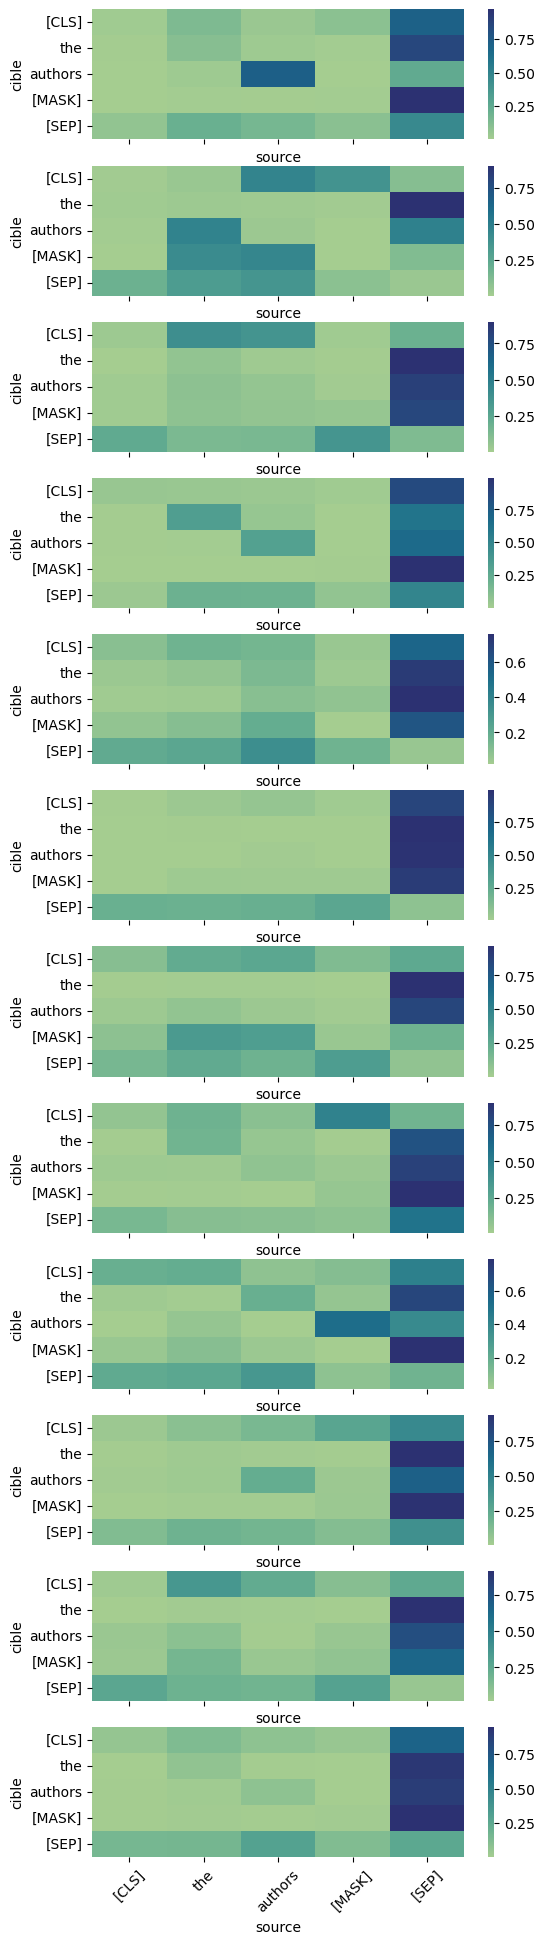

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

n_heads = attentions[-1].shape[1]
fig,ax = plt.subplots(n_heads, 1, figsize=(6, n_heads * 2), sharex=True)

for layer in range(n_heads):
    plt.sca(ax[layer])
    self_attention = attentions[-1][0, layer, :].detach() #.sum(axis=0)#.max(axis=0)[0]

    plot = sns.heatmap(pd.DataFrame(data=self_attention.numpy(),
                             index=tokens,
                             columns=tokens), cmap="crest")
    plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
    plot.set_xlabel("source")
    plot.set_ylabel("cible")

## View hidden states

In [18]:
hidden_states = output.hidden_states
print(len(hidden_states))   # 13
print(hidden_states[-1].shape)  # Each hidden_state is a `[batch_size ✕ input_sequence_length ✕ 768]`.

13
torch.Size([1, 5, 768])


In [38]:
# the first hidden state on the last layer
first_hidden_state_head = hidden_states[-1][0, :].detach()
first_hidden_state_head.shape

torch.Size([5, 768])

In [ ]:
import pickle

def load_model_outputs(checkpoint, file_path='model_outputs.pkl'):
    """
    Load the attention weights and hidden states from a pickle file.

    - checkpoint: (str) The name of the checkpoint.
    - file_path: (str) The path to the pickle file.

    Returns: (tuple) A tuple containing a list of attention weights and a list of hidden states.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    attentions = [torch.tensor(attention) for attention in data[checkpoint]['attentions']]
    hidden_states = [torch.tensor(hidden_state) for hidden_state in data[checkpoint]['hidden_states']]
    
    return attentions, hidden_states